# Basic usage of modified transformers library (modification have been done only for BERT)

## Install the changed library (only first once)

1. move into the modified library
> $ cd transformers

1. install using pip (I recommend editable mode (-e option).)
> $ pip install -e .

1. please install pytorch (https://pytorch.org/) \
 e.g., 
 > $ pip install torch torchvision

## Usage

In [1]:
import torch
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Load pretrained model/tokenizer
model_name = "bert-large-uncased-whole-word-masking"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)
# tokenizer = RobertaTokenizer.from_pretrained(model_name)
# model = RobertaModel.from_pretrained(model_name).to(device)
model.eval()

# Tokenize text and convert to ids. 
input_ids = torch.tensor([tokenizer.encode("A 41 year old person age is [MASK] than a 42 year old person .", add_special_tokens=True)]).to(device)
#input_ids = torch.tensor([tokenizer.encode("A 41 year old person age is <mask> than a 42 year old person .", add_special_tokens=True)]).to(device)
#input_ids = torch.tensor([tokenizer.encode("The size of a feather is usually much <mask> than the size of a nail .", add_special_tokens=True)]).to(device)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

['[CLS]', 'a', '41', 'year', 'old', 'person', 'age', 'is', '[MASK]', 'than', 'a', '42', 'year', 'old', 'person', '.', '[SEP]']


In [3]:
# If you want to extract vector norms (i.e., ||f(x)||, ||αf(x)||, ||Σαf(x)||), please set the argument "output_norms" to True.
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

In [4]:
# Returned variable "norms" is a tuple which has 12 elements (equal to the number of layers).
print(type(norms))
print(len(norms))

<class 'tuple'>
24


In [5]:
# Each element is a tuple which consists of 3 elements: ||f(x)||, ||αf(x)||, and ||Σαf(x)||.
layer = 5
print(type(norms[layer-1]))
print(len(norms[layer-1]))

fx_norm, afx_norm, summed_afx_norm = norms[layer-1]

<class 'tuple'>
3


In [6]:
# shape of fx_norm (||f(x)||) is (batch, num_heads, seq_length)
print("shape of ||f(x)||:", fx_norm.size())

shape of ||f(x)||: torch.Size([1, 16, 17])


In [7]:
# shape of afx_norm (||αf(x)||) is (batch, num_heads, seq_length, seq_length)
print("shape of ||αf(x)||:", afx_norm.size())

shape of ||αf(x)||: torch.Size([1, 16, 17, 17])


In [8]:
# shape of summed_afx_norm (||Σαf(x)||) is (batch, seq_length, seq_length)
print("shape of ||Σαf(x)||:", summed_afx_norm.size())

shape of ||Σαf(x)||: torch.Size([1, 17, 17])


## Comparison with attention weight

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the layer and head you want to check. (layer: 1~12, head: 1~12)

layer = 7
head = 5

### Attention weight visualization (Head-level visualization)

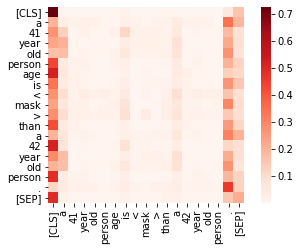

In [28]:
plt.figure() 
attention = attentions[layer-1][0][head-1].cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)

In [9]:
from tqdm.auto import tqdm

In [10]:
layer2head = {2: [2, 3], 3: [12], 5: [2], 6: [6], 12: [3], 13: [4], 15: [8], 16: [0, 8], 17: [2, 5, 10]}

In [22]:
num_heads = model.config.num_attention_heads
num_layers = model.config.num_hidden_layers
#fig, axes = plt.subplots(num_layers, num_heads)
#fig = plt.figure()
#fig.suptitle(f"BERT-Large-WWM Attention Norms")
fig = plt.figure() #plt.figure(figsize=(16, 12)) 
fig.set_figheight(120)
fig.set_figwidth(160)
#plt.rcParams["figure.figsize"] = (15 * num_layers, 15 * num_heads)
for layer in tqdm(range(num_layers)):
    for head in range(num_heads):
        plt.subplot(num_heads, num_layers, num_layers * head + layer + 1)
        if (layer == 0) or (layer == 23) or ((layer in layer2head) and (head in layer2head[layer])):
            afx_norm = norms[layer][1]
            norm = afx_norm[0][head].cpu().numpy()
            df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
            sns.heatmap(df,cmap="Reds",square=True)
            plt.gcf().subplots_adjust(bottom=0.2)
        
plt.savefig(f"{model_name}-attention-important_all.png", bbox_inches="tight")
plt.close(fig)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
len(axes[0])

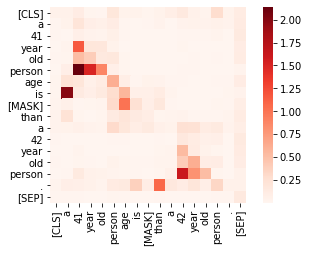

In [11]:
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Attention weight visualization (Layer-level visualization)

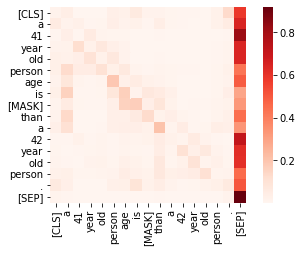

In [12]:
plt.figure() 
attention = attentions[layer-1][0].mean(0).cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)

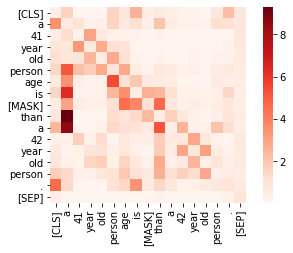

In [13]:
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)